In [4]:
using PyCall
using PyPlot
using FFTW
using LinearAlgebra
using JLD2
using YAML
FFTW.set_num_threads(16)

config = YAML.load_file("config.yaml")
n = 1

1

In [5]:
#I'm a little confused what this is doing exactly
config_str = ""
counter = 1
for i in 0:(config["number_subboxes"]-1)
    for j in 0:(config["number_subboxes"]-1)
        for k in 0:(config["number_subboxes"]-1)
            global counter, config_str
            if counter == n
                config_str = "$(i)$(j)$(k)"
            end
            counter += 1
        end
    end
end
config["run_name"] = config["run_name"] * "_" * config_str
print(config["run_name"])

TNG300-1_1024_000

In [6]:
den = load(config["output_directory"] * config["run_name"] * ".jld2")["den"];

In [7]:
using CosmoMMF

In [10]:
Rs = (√2) .^ (0:10)
@time combined_NEXUS = CosmoMMF.maximum_signature(Rs, den; alg=:NEXUS);
@time combined_NEXUSPLUS = CosmoMMF.maximum_signature(Rs, den; alg=:NEXUSPLUS);

2616.746471 seconds (1.77 M allocations: 1.516 TiB, 4.72% gc time, 0.03% compilation time)
2455.082383 seconds (8.81 M allocations: 1.370 TiB, 4.68% gc time, 0.12% compilation time)


In [12]:
# TNG300-3 specifications
DM_particle_mass = 0.302538487429177 # in units of 1e10 Msun/h
N_DM = 244140625
N_cells = size(den,1) * size(den,2) * size(den,3)
# an average grid cell has 
mass_of_average_cell = DM_particle_mass * N_DM / N_cells

0.2817609230328137

In [13]:
using Images

In [14]:
function get_clusbools(thresh, max_cats::AbstractArray{T,4}) where T
    test_bools = (max_cats[:,:,:,1] .> thresh)
    
    nx, ny, nz = size(max_cats)[1:3]

    # step 2. tag components
    components = Images.label_components(test_bools)
    max_component = maximum(components)

    print("Components: $(max_component)\n")
    
    # step 3. loop through each component, assess average overdensity
    masses = zeros(T, max_component)
    volume = zeros(T, max_component)

    compare = zeros(nx,nx,nx);

    for i in 1:nx
        for j in 1:nx
            for k in 1:nx
                if components[i,j,k] != 0
                    masses[ components[i,j,k] ] += den[i,j,k]
                    volume[ components[i,j,k] ] += 1.0
                end
            end
        end
    end
    
    compbool = (masses .> 5e3 / mass_of_average_cell)  .& (volume .> 1)
    println( "viri frac: ", sum( (volume .> 1) .& (masses ./ volume .> 370) ) / max_component)
    println( "mass frac: ", sum(masses[compbool])   / sum(den) )
    
    clusbool = zeros(Bool, nx, nx, nx)
    for i in 1:nx
        for j in 1:ny
            for k in 1:nz
                if components[i,j,k] != 0
                    if compbool[components[i,j,k]]
                        clusbool[i,j,k] = true
                    end
                end
            end
        end
    end
    
    clusbool
end

get_clusbools (generic function with 1 method)

In [34]:
clusbool = get_clusbools(240.0, combined_NEXUS);

Components: 1120
viri frac: 0.5321428571428571
mass frac: 0.19020891239608562


In [35]:
# TNG300-3 specifications
DM_particle_mass = 0.302538487429177 # in units of 1e10 Msun/h
N_DM = 244140625
N_cells = size(den,1) * size(den,2) * size(den,3)
# an average grid cell has 
mass_of_average_cell = DM_particle_mass * N_DM / N_cells

0.2817609230328137

In [36]:
cluster_signature = reshape(combined_NEXUS[:,:,:,1], N_cells)
filament_signature = reshape(combined_NEXUSPLUS[:,:,:,2], N_cells)
wall_signature = reshape(combined_NEXUSPLUS[:,:,:,3], N_cells);

In [37]:
function get_sig_plot(sig_vec, f)
    log10S = collect(-2:0.2:3)
    yy = zeros(Float64, size(log10S))
    for i in 1:size(yy,1)
        yy[i] = sum(
            f[sig_vec .> (10^log10S[i])]
            ) 
    end
    
    dydx = abs.( diff(yy.^2) ./ diff( log10S ) );
    midx = (log10S[1:size(log10S,1)-1] .+ log10S[2:size(log10S,1)]) ./ 2;
    return (10 .^ midx), dydx
end

not_clus_flat = reshape( clusbool .== false, N_cells );
filament_valid = filament_signature[ not_clus_flat ];
flat_den_valid = reshape(den, N_cells)[ not_clus_flat ];

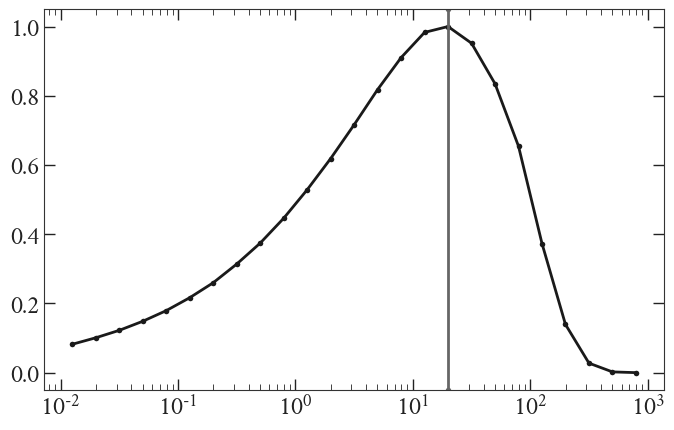

In [38]:
S_fil, dM2_fil = get_sig_plot(filament_valid, flat_den_valid)
max_dM, ind = findmax(dM2_fil)
filament_thresh = S_fil[ind]
plt.plot(S_fil, dM2_fil ./ maximum(dM2_fil))
plt.axvline(filament_thresh)
plt.xscale("log")

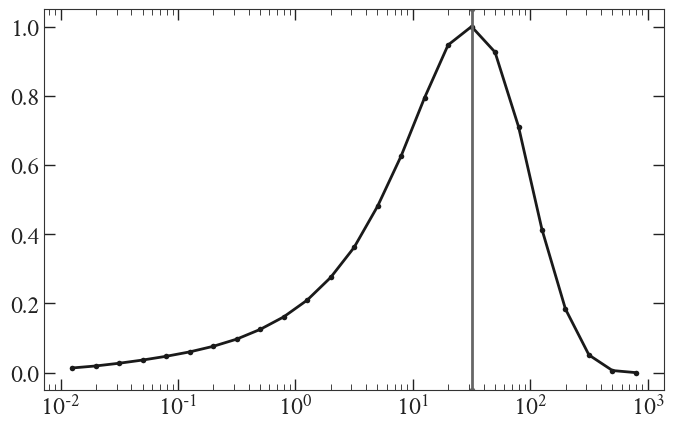

PyObject <matplotlib.lines.Line2D object at 0x7fdf4210d850>

In [39]:
wall_valid_filt = (not_clus_flat) .& (filament_signature .< filament_thresh)
wall_valid = wall_signature[wall_valid_filt];
wall_den_valid = reshape(den, N_cells)[wall_valid_filt];

S_wall, dM2_wall = get_sig_plot(wall_valid, wall_den_valid)
max_dM, ind = findmax(dM2_wall)
wall_thresh = S_wall[ind]
plt.plot(S_wall, dM2_wall ./ maximum(dM2_wall))
plt.xscale("log")
plt.axvline(wall_thresh)

In [40]:
# cluster_thresh = 190
# clusbool = np.load("clusden.npy")
cluster = den[clusbool]
filbool = (combined_NEXUSPLUS[:,:,:,2] .> filament_thresh) .& (.!clusbool)
filament = den[filbool]
wallbool = (combined_NEXUSPLUS[:,:,:,3] .> wall_thresh) .& .!(filbool .| clusbool)
wall = den[wallbool];

total_mass = sum(den)
println(sum(cluster) / total_mass)
println(sum(filament) / total_mass)
println(sum(wall) / total_mass)

0.1902089123960856
0.4423102642303466
0.21823409852213554


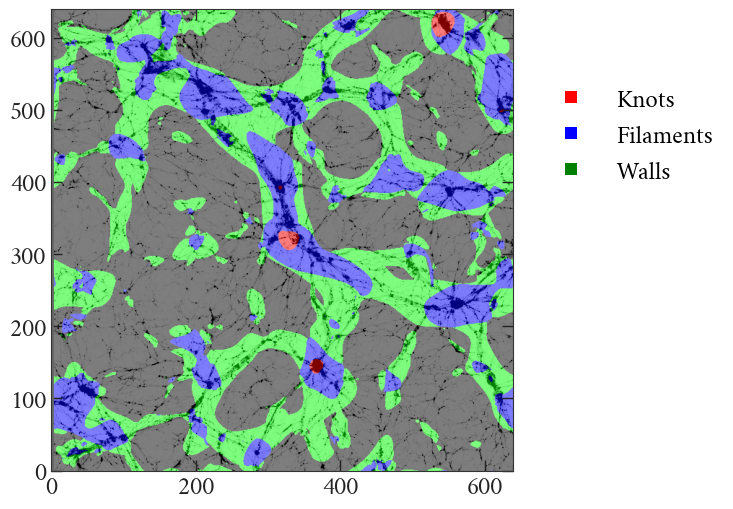

PyObject <matplotlib.legend.Legend object at 0x7fdf438f8340>

In [43]:
fig, ax = subplots(1,1,figsize=(6,6))

slice = 100
densq = -clamp.(den[:,:,slice], 0, 3)/3 .+ 1 # density plot
densq ./= 2

ax.imshow(  cat( [
            transpose(clamp.(densq + (clusbool[:,:,slice])[:,:,1] / 2, 0.0,1.0)), 
            transpose(clamp.(densq + wallbool[:,:,slice] / 2, 0.0,1.0)),
            transpose(clamp.(densq + filbool[:,:,slice] / 2, 0.0,1.0))]..., dims=3) , origin="lower" )

plt.axvline()

plt.plot([],[],"rs", label="Knots")
plt.plot([],[], "bs", label="Filaments")
plt.plot([],[], "gs", label="Walls")
plt.legend(loc=(1.05,0.6))
# get(ax,0).set_title("clusters")